# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Net4

In [2]:
! nvidia-smi

Fri Dec 13 23:02:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   22C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
train_transforms = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
        transforms.RandomRotation((-5.0, 5.0), fill=(0.1307,)),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Test data transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net4().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
           Conv2d-13           [-1, 12, 10, 10]             864
             ReLU-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  Net4().to(device)
EPOCHS = 15
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)  # large learning rate
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, epochs=EPOCHS, steps_per_epoch=len(train_loader))

     


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2293274998664856 Batch_id=468 Accuracy=79.19: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s] 



Test set: Average loss: 0.2111, Accuracy: 9643/10000 (96.43%)

EPOCH: 1


Loss=0.1353951245546341 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s] 



Test set: Average loss: 0.0931, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Loss=0.06196576729416847 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s] 



Test set: Average loss: 0.0718, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.10475406050682068 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s] 



Test set: Average loss: 0.0493, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.04610242322087288 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s] 



Test set: Average loss: 0.0446, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.028601786121726036 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]



Test set: Average loss: 0.0385, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.13775813579559326 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s] 



Test set: Average loss: 0.0365, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.10840465873479843 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s] 



Test set: Average loss: 0.0343, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.04840557277202606 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s] 



Test set: Average loss: 0.0326, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.017316268756985664 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]



Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.08782398700714111 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s] 



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.06251735240221024 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s] 



Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.023871226236224174 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]



Test set: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.08515731245279312 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]  



Test set: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.058065202087163925 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]



Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

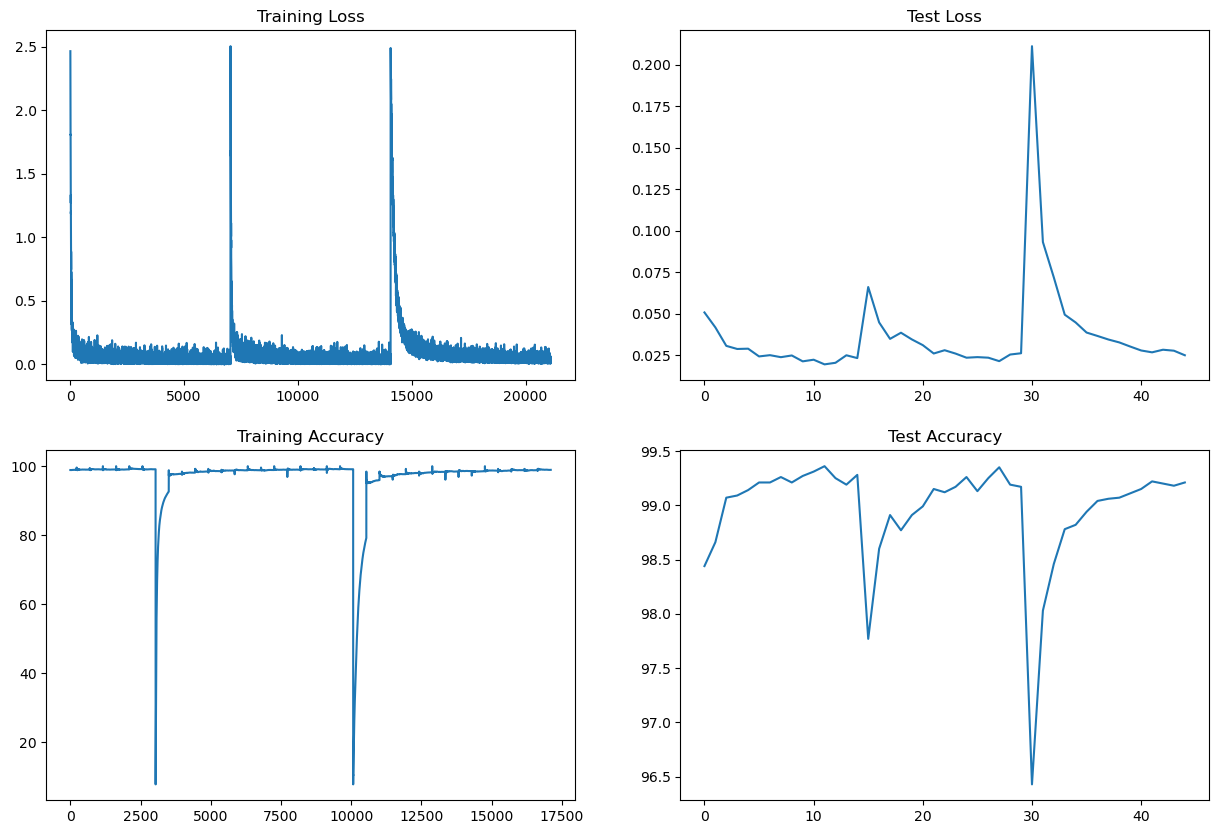

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [17]:
fig.savefig('exp4.png')

In [18]:

import matplotlib.pyplot as plt
import numpy as np
def evaluate_model(model: nn.Module, loader, device: torch.device):
    cols, rows = 4,6
    figure = plt.figure(figsize=(20, 20))
    for i in range(1, cols * rows + 1):
        k = np.random.randint(0, len(loader.dataset)) # random points from test dataset
    
        img, label = loader.dataset[k] # separate the image and label
        img = img.unsqueeze(0) # adding one dimention
        pred=  model(img.to(device)) # Prediction 

        figure.add_subplot(rows, cols, i) # making the figure 
        plt.title(f"Predcited label {pred.argmax().item()}\n True Label: {label}") # title of plot
        plt.axis("off") # hiding the axis
        plt.imshow(img.squeeze(), cmap="gray") # showing the plot

    plt.show()
    plt.savefig('eval_4.png')

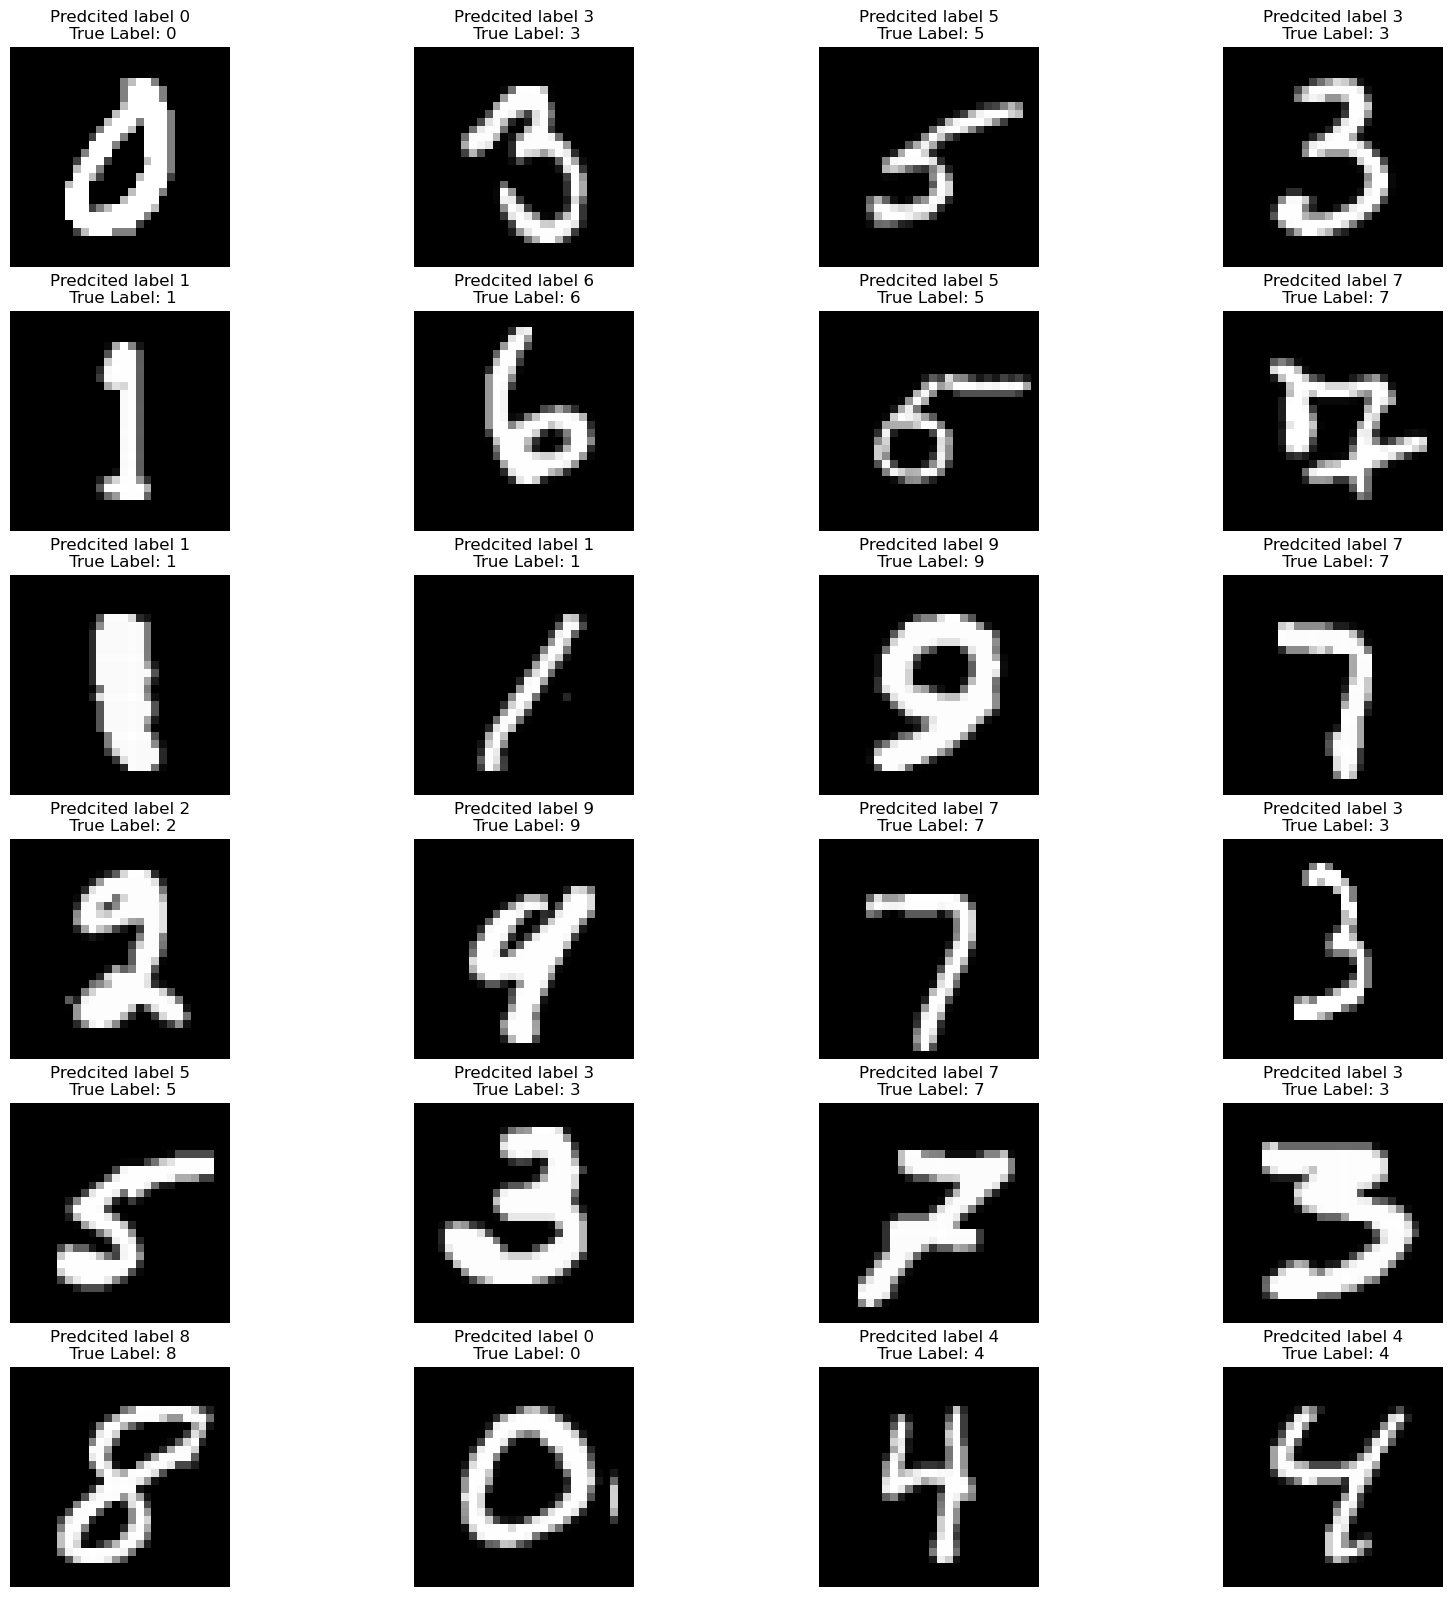

<Figure size 640x480 with 0 Axes>

In [19]:
evaluate_model(model, test_loader, device)

In [21]:
!hostname

ip-172-31-39-183


In [22]:
! cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.5 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.5 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy
